In Google Colab default Tensorflow is still 1.15.0, but I'm using some tf2 features


In [0]:
import tensorflow as tf
if (tf.__version__=='1.15.0'):
  !pip uninstall tensorflow
  !pip install -U tensorflow-gpu==2.0.0

#after you have to restart the runtime, if run in colab

In the first lines, we upload the zip file.

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import drive
drive.mount('/content/drive')


#Give it the directory to unzip it from (or upload it manually and skip this)


!unzip -uq "/content/drive/My Drive/POLIMI/AN2DL/ann-and-dl-image-segmentation.zip" -d "/content/"

Then, we import the necessary libraries, set the seed, set the directory and monitor the GPUs

In [2]:
import os
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import numpy as np
import datetime



# Set the seed for easy reproducibility
SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

# Set GPU memory growth 
# Allows to only as much GPU memory as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Working on Colab, I sometimes encountered a OOM error. In order to monitor the GPU and eventually kill the session I used this snippet of code

In [3]:
"""
# memory footprint support libraries/code

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

!kill -9 -1
"""

'\n# memory footprint support libraries/code\n\n!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi\n\n!pip install gputil\n!pip install psutil\n!pip install humanize\n\nimport psutil\nimport humanize\nimport os\nimport GPUtil as GPU\nGPUs = GPU.getGPUs()\n# XXX: only one GPU on Colab and isn’t guaranteed\ngpu = GPUs[0]\ndef printm():\n process = psutil.Process(os.getpid())\n print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))\n print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))\nprintm() \n\n!kill -9 -1\n'

We build the generators and decide the training/validation split. After many trials, I've found data augmentation wasn't helping. This is obvious in the case of rotations, zooms etc where we only add black pixels (if fill mode = constant), but I've also found flips not to help. I didn't have enough time to try it, but edge detection and color augmentation might be useful
 

In [0]:
# ImageDataGenerator
# ------------------


from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

split = 0.2
# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks

#aggiungere cambi di colore e cose simili 


if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='constant',
                                            cval=0,
                                            rescale=1./255,
                                            validation_split = split)
    train_mask_data_gen = ImageDataGenerator(
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             fill_mode='constant',
                                             cval=0,
                                             rescale = 1./255,
                                             validation_split = split)
else:
    train_img_data_gen = ImageDataGenerator(rescale=1./255,
                                            validation_split = split)
    train_mask_data_gen = ImageDataGenerator(rescale=1./255,
                                             validation_split = split)

valid_img_data_gen = ImageDataGenerator(rescale=1./255,validation_split = split)
valid_mask_data_gen = ImageDataGenerator(rescale=1./255,validation_split = split)

We create the generators to read the images from our directory, set batch size, image dimensions and set the classes coherently for images and masks



In [5]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
dataset_dir = os.path.join(cwd, '/content/Segmentation_Dataset')

# Batch size
bs = 16

# img shape
img_h = 256   #height of the incoming images
img_w = 256   #width of the incoming images

num_classes=2

classes = {'background' : 0,
           'building' : 1 
          }



training_dir = os.path.join(dataset_dir, 'training')
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, # Because we have no class subfolders in this case
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       seed=SEED,
                                                       subset = 'training')  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs,
                                                         class_mode=None, # Because we have no class subfolders in this case
                                                         shuffle=True,
                                                         interpolation='bilinear',
                                                         seed=SEED,
                                                         subset = 'training',
                                                         color_mode = 'grayscale')
train_gen = zip(train_img_gen, train_mask_gen)

# Validation
validation_dir = os.path.join(dataset_dir, 'training')
valid_img_gen = valid_img_data_gen.flow_from_directory(os.path.join(validation_dir, 'images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       class_mode=None, 
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       seed=SEED,
                                                       subset = 'validation'
                                                       )

valid_mask_gen = valid_mask_data_gen.flow_from_directory(os.path.join(validation_dir, 'masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs, 
                                                         class_mode=None, 
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         seed=SEED,
                                                         subset = 'validation',
                                                         color_mode = 'grayscale'
                                                         )
valid_gen = zip(valid_img_gen, valid_mask_gen)



Found 6118 images belonging to 1 classes.
Found 6118 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.
Found 1529 images belonging to 1 classes.


Now we can use the defined generators and prepare the targets by converting to floats (in order to have type compatibility afterwards as there is no automatic cast)

In [0]:
# Create Dataset objects
# ----------------------

# Training
# --------
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))

def prepare_target(x_, y_):
    y_=tf.cast(y_,tf.float32)
    return x_, y_

train_dataset = train_dataset.map(prepare_target)

# Repeat
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 1]))
valid_dataset = valid_dataset.map(prepare_target)

# Repeat
valid_dataset = valid_dataset.repeat()


We can, as usual, look at some images. Here I also found by inspection that data augmentation would probably not help.

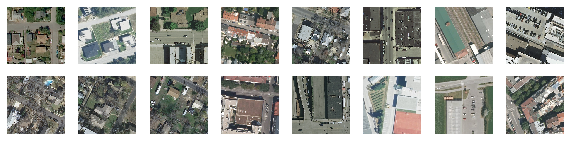

In [7]:
import matplotlib.pyplot as plt

def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(bs):
      ax = plt.subplot(bs/2,bs/2,n+1)
      plt.imshow(image_batch[0][n])
      im = image_batch[1][n][:,:,0]
      #plt.imshow(im, cmap=plt.cm.binary)
      plt.axis('off')



image_batch = next(train_gen)
show_batch(image_batch)

Now, we define the Dice loss we are going to use. I've also tried Tversky loss as the pixel distribution is not balanced, but it didn't seem to better the model. I choose dice loss over binary crossentropy as it is the most coherent with our goal, which is optimizing the IoU metric.

In [0]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K


epsilon = 1e-5
smooth = 1e-1

def dsc(y_true, y_pred):
    smooth = 0.1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

I use the IoU function defined in the competition page.

In [0]:
def my_IoU(y_true, y_pred):
    # from probability to predicted class {0, 1}
    y_pred = tf.cast(y_pred > 0.5, tf.float32) # when using sigmoid. Use argmax for softmax

    # A and B
    intersection = tf.reduce_sum(y_true * y_pred)
    # A or B
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    # IoU
    return intersection / union

Then, I build the model. First, I tried with the model used in class, which was,however, too weak. In fact, it got stuck in the local minimum corresponding to an 'all buildings' configuration, as predicting like this got it to ~ 30% validation accuracy and yielding a 0.03630 score in the Kaggle competition. Even using SGD + Nesterov momentum and a higher variance weight distribution didn't help. So, I decided to use a more powerful model, a Unet, which, with the following final configuration, I've found to be working well. It seems like dropout doesn't really help in the case of a Unet, while batch normalization, which I hadn't used in the classification challenge, seems to do the job. I tried using a deeper network too, but, at the same time, the training took a really long time (280 s per epoch) and it was not worth it, as there too many parameters to train and the network struggled to converge to a good minimum. For the future, I would have like to try a ResUnet, a PSPnet or a DeepLabV3 network, as I think they might have performed better on the task.

Adam, as it often happens, proved to be a solid choice in comparison to Adagrad and SGD, and, for the rest, I sticked with earlystopping and a learning rate adapter (which proved to be useful even if I used Adam) as in the classification task.

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


def unet_model(n_classes=2, n_filters_start=32, growth_factor=2, upconv=True):
    droprate=0.2
    n_filters = n_filters_start
    inputs = Input((img_h,img_w, 3))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_0 = Dropout(droprate)(pool4_0)

    n_filters *= growth_factor
    pool4_0 = BatchNormalization()(pool4_0)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_0)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_2)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_2)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    pool4_2 = BatchNormalization()(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(droprate)(conv5)

    n_filters //= growth_factor
    if upconv:
        up6 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_2])
    else:
        up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_2])
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = Dropout(droprate)(conv6)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    loss = dice_loss

    lr = 1e-3
    optimizer = Adam(learning_rate=lr)
    metrics = [my_IoU]

    model.compile(optimizer=Adam(), loss = loss, metrics = metrics)
    return model

In [20]:

model = unet_model(n_classes=2, n_filters_start=32, growth_factor=2, upconv=False)

# Visualize created model as a table
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_59[0][0]                  
____________________________________________________________________________________________

I then fit my model.

In [0]:
filepath = '/content/drive/My Drive/POLIMI/AN2DL/Lab/Challenge2'

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)

LR_adapter_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks = [es_callback,LR_adapter_callback]

#model.load_weights('/content/drive/My Drive/POLIMI/AN2DL/Lab/Retine/cnn_seg4.h5')
model.fit(x=train_dataset,
          epochs=70,  #### set repeat in training dataset
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks,
          verbose=1)

#model.save(os.path.join('/content/drive/My Drive/POLIMI/AN2DL/Lab/Retine/cnn_seg.h5'))

In [0]:
def rle_encode(img):
      # Flatten column-wise
      pixels = img.T.flatten()
      pixels = np.concatenate([[0], pixels, [0]])
      runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
      runs[1::2] -= runs[::2]
      return ' '.join(str(x) for x in runs)

Then, I encode the results in the correct format

In [0]:
from PIL import Image
import itertools

final_path = os.path.join(dataset_dir, 'test/images/img')
image_filenames = next(os.walk(final_path))[2]  #I get the names of the images

results = {} #empty dictionary for results, which I will then make into a csv file

#count=0

for image_name in image_filenames:
  
   img = Image.open(final_path+'/'+image_name).convert('RGB')
   img=img.resize((img_h,img_w))
   img_array = np.array(img)
   img_array = np.expand_dims(img_array, 0)
   img_array = np.true_divide(img_array,255)

   mask_prediction = model.predict(img_array)[0]
   mask_prediction = mask_prediction > 0.5

   img_name_def = os.path.splitext(image_name)[0]
   results[img_name_def] = rle_encode(mask_prediction) 
   #print(count)
   #count = count + 1

  


In [0]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(csv_fname, 'w') as f:

      f.write('ImageId,EncodedPixels,Width,Height\n')

      for key, value in results.items():
          f.write(key + ',' + str(value) + ',' + '256' + ',' + '256' + '\n')




In [0]:
create_csv(results,'/content/drive/My Drive/POLIMI/AN2DL/Lab')

It's also often useful to look at images and masks to get an idea of the performance. 

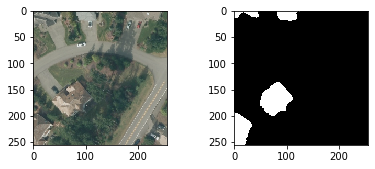

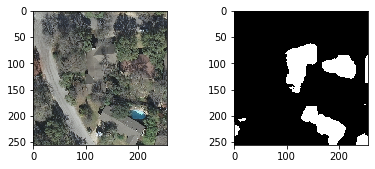

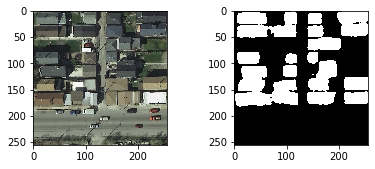

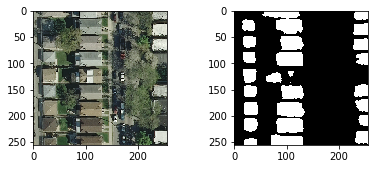

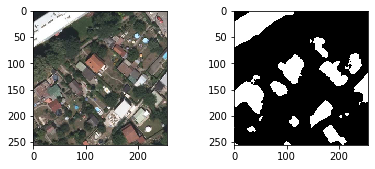

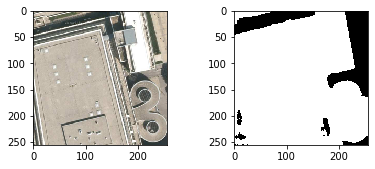

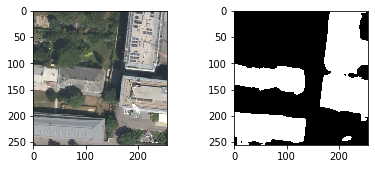

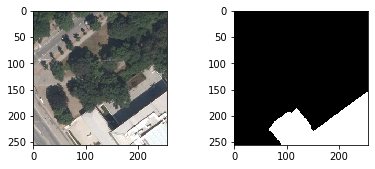

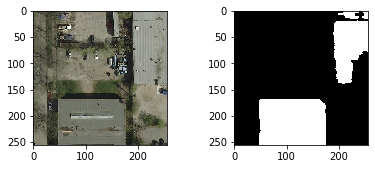

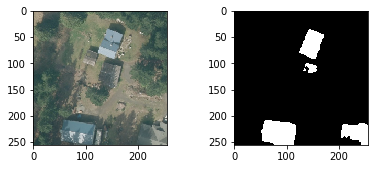

In [0]:
"""
for image_name in itertools.islice(image_filenames , 5, 15):
  
  img = Image.open(final_path+'/'+image_name).convert('RGB')
  img=img.resize((img_h,img_w))
  img_array = np.array(img)
  img_array = np.expand_dims(img_array, 0)
  img_array=np.true_divide(img_array,255)

  mask_prediction = model.predict(img_array)[0]
  mask_prediction = mask_prediction > 0.5
  
  
  img_name_def = os.path.splitext(image_name)[0]
  results[img_name_def] = rle_encode(mask_prediction) 
  
  fig = plt.figure()
  fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
  ax = fig.add_subplot(1,2,1)
  ax.imshow(img)
  ax = fig.add_subplot(1,2,2)
  mask_prediction = mask_prediction[:,:,-1]
  ax.imshow(mask_prediction,cmap='gray')
  """

On the whole, as I mentioned before, I think there are some margins for improvement, even though the network performs decently. I'm looking forward to having more time to improve in the augmentation part and to try different architectures, even if I really like the concept of a Unet network.